In [326]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

### Pipeline psuedo code
    n = look back window
    k = number of PCs to keep

    for each time point t:
        p = number of stocks in investable universe at time t
        Define an n x p feature matrix X (lagged returns)

        Perform PCA on X
        Keep the first k PCs in an n x k matrix Z

    for each stock s in the investable universe at time t:
        Define an n x 1 outcome vector y (future returns of stock s)
        Perform a linear regression of y on Z
        Predict y for stock s at time t+1

## Data Preparation

In [327]:
returns = pd.read_pickle("./Data/returns.pkl")
returns = returns.iloc[1:]

In [328]:
drop_columns = []

for col in returns.columns:
    if returns[col].isnull().all() == True:
        drop_columns.append(col)
        
returns.drop(columns=drop_columns, inplace=True)

## Pipeline

In [329]:
def get_investable(t, n):
    """"Find stocks in investable universe at time t+1
    (stocks in the S&P500 that have prices recorded for the last n days)"""
    
    df_investable = returns.copy(deep = True).sort_index(ascending = False)
    
    #add 1 date to get the test features in investable
    t = t + pd.DateOffset(1)
    n += 1
    
    #if t is now a non-trading day, advance until we reach a valid trading day
    while t not in df_investable.index:
        t = t + pd.DateOffset(1)
    
    t_index = df_investable.index.get_loc(t)
    
    #take n_rows worth of data upto time specified
    df_investable = df_investable.iloc[t_index:t_index + n]
    
    #find all stocks that exist in the S&P at this time period
    investable_universe = []
    for col in df_investable.columns:
        if ~df_investable[col].iloc[:n].isna().any():
            investable_universe.append(col)
        
    df_investable = df_investable[investable_universe]
    
    return df_investable

In [579]:
def apply_PCA(inv, k):
    X = inv.iloc[1:, :]
    pca = PCA(n_components = k) 
    inv_scaled = StandardScaler().fit_transform(X)   
    principal_components = pca.fit_transform(inv_scaled)

    df = pd.DataFrame(data = principal_components)
    
    #For explained variance table
    components = pca.components_
    component_explained_var = pca.explained_variance_ratio_ * 100
    
    comp_names = [str(i) for i in range(1, len(component_explained_var) + 1)]

    pca_results = pd.DataFrame(data = component_explained_var, index = comp_names)
    pca_results.columns = ['Explained variance (%)']
    pca_results['Explained variance (%)'] = pca_results['Explained variance (%)'].round(2)
    
    return df#, pca_results

In [630]:
t = pd.to_datetime('2020-05-28')
inv = get_investable(t, 200)
X, df = apply_PCA(inv, 20)

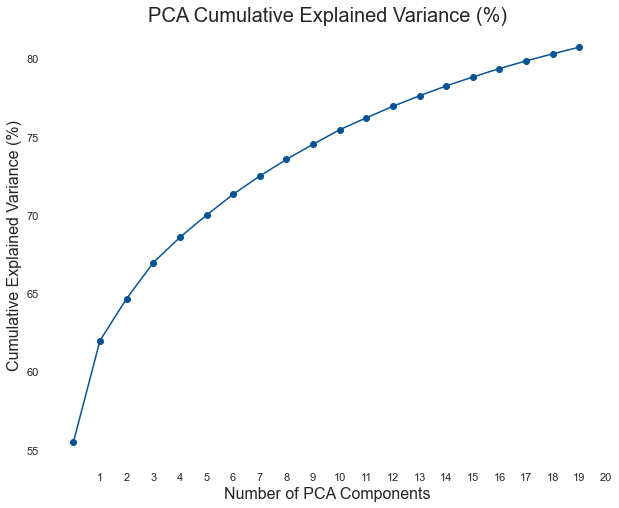

In [629]:
fig, axes = plt.subplots(figsize=(10,8))
plt.plot(np.cumsum(df), color = '#065394', marker = 'o')
plt.xticks([i for i in range(1, 21)])
plt.xlabel('Number of PCA Components', fontsize = 16)
plt.ylabel('Cumulative Explained Variance (%)', fontsize = 16)
plt.title('PCA Cumulative Explained Variance (%)', fontsize = 20)
axes.grid(axis = 'x')
plt.show()

In [483]:
def define_y(inv, stock):
    y = inv[[stock]].iloc[:-1]
    
    return y

In [465]:
def train_test(X, y):
    X_train = X.iloc[1:, :]
    X_test = X.iloc[0:1, :]
    y_train = y.iloc[1:]
    y_test = y.iloc[0:1]
    
    return X_train, y_train, X_test, y_test

In [333]:
def model_fit(X_train, y_train):
    model = sklearn.linear_model.LinearRegression()
    model.fit(X_train, y_train)
    
    return model

In [334]:
def model_predict(model, X_test):
    yhat = model.predict(X_test)
    
    return yhat

In [513]:
def predict_returns(t, n, k):
    inv = get_investable(t, n)
    X = apply_PCA(inv, k)
    
    returns_t = pd.DataFrame(index = inv.columns, columns = ['Pred', 'Actual'])
    
    for stock in inv.columns:
        y = define_y(inv, stock)
        X_train, y_train, X_test, y_test = train_test(X, y)
        model = model_fit(X_train, y_train)
        yhat = model_predict(model, X_test)[0][0]
        returns_t['Pred'].loc[stock] = yhat
        returns_t['Actual'].loc[stock] = y_test.values[0][0]
    
    return returns_t

In [508]:
def rank_stocks(returns, num_stocks):
    pred_returns = returns.sort_values(by = 'Pred', ascending = False)
    topn = pred_returns.head(num_stocks)
    botn = pred_returns.tail(num_stocks)
    
    return topn, botn

In [509]:
def portfolio_return(topn, botn, returns):
    return_t = topn['Actual'].mean() - botn['Actual'].mean()
    
    return return_t

In [515]:
def pipeline(n, k, num_stocks):

    time_range = returns.loc['2007':'2021'].index
    
    portfolio = pd.DataFrame(index = time_range, columns = ['Portfolio Return'])
    
    count = 0
    for t in time_range[:-1]:
        pred_actual = predict_returns(t, n, k)
        topn, botn = rank_stocks(pred_actual, num_stocks)
        return_t = portfolio_return(topn, botn, pred_actual)
        t_index = time_range.get_loc(t) + 1
        portfolio['Portfolio Return'].loc[time_range[t_index]] = return_t
        
        count +=1
        print(f'{(count/len(time_range))*100:.2f}% complete')
    
    portfolio['Portfolio Return'] = portfolio['Portfolio Return'].astype('float')
    
    return portfolio

In [516]:
portfolio = pipeline(200, 20, 5)

0.03% complete
0.06% complete
0.08% complete
0.11% complete
0.14% complete
0.17% complete
0.19% complete
0.22% complete
0.25% complete
0.28% complete
0.30% complete
0.33% complete
0.36% complete
0.39% complete
0.41% complete
0.44% complete
0.47% complete
0.50% complete
0.52% complete
0.55% complete
0.58% complete
0.61% complete
0.63% complete
0.66% complete
0.69% complete
0.72% complete
0.74% complete
0.77% complete
0.80% complete
0.83% complete
0.85% complete
0.88% complete
0.91% complete
0.94% complete
0.96% complete
0.99% complete
1.02% complete
1.05% complete
1.08% complete
1.10% complete
1.13% complete
1.16% complete
1.19% complete
1.21% complete
1.24% complete
1.27% complete
1.30% complete
1.32% complete
1.35% complete
1.38% complete
1.41% complete
1.43% complete
1.46% complete
1.49% complete
1.52% complete
1.54% complete
1.57% complete
1.60% complete
1.63% complete
1.65% complete
1.68% complete
1.71% complete
1.74% complete
1.76% complete
1.79% complete
1.82% complete
1.85% comp

14.78% complete
14.81% complete
14.83% complete
14.86% complete
14.89% complete
14.92% complete
14.94% complete
14.97% complete
15.00% complete
15.03% complete
15.05% complete
15.08% complete
15.11% complete
15.14% complete
15.16% complete
15.19% complete
15.22% complete
15.25% complete
15.27% complete
15.30% complete
15.33% complete
15.36% complete
15.38% complete
15.41% complete
15.44% complete
15.47% complete
15.49% complete
15.52% complete
15.55% complete
15.58% complete
15.61% complete
15.63% complete
15.66% complete
15.69% complete
15.72% complete
15.74% complete
15.77% complete
15.80% complete
15.83% complete
15.85% complete
15.88% complete
15.91% complete
15.94% complete
15.96% complete
15.99% complete
16.02% complete
16.05% complete
16.07% complete
16.10% complete
16.13% complete
16.16% complete
16.18% complete
16.21% complete
16.24% complete
16.27% complete
16.29% complete
16.32% complete
16.35% complete
16.38% complete
16.40% complete
16.43% complete
16.46% complete
16.49% c

28.92% complete
28.95% complete
28.98% complete
29.00% complete
29.03% complete
29.06% complete
29.09% complete
29.11% complete
29.14% complete
29.17% complete
29.20% complete
29.23% complete
29.25% complete
29.28% complete
29.31% complete
29.34% complete
29.36% complete
29.39% complete
29.42% complete
29.45% complete
29.47% complete
29.50% complete
29.53% complete
29.56% complete
29.58% complete
29.61% complete
29.64% complete
29.67% complete
29.69% complete
29.72% complete
29.75% complete
29.78% complete
29.80% complete
29.83% complete
29.86% complete
29.89% complete
29.91% complete
29.94% complete
29.97% complete
30.00% complete
30.02% complete
30.05% complete
30.08% complete
30.11% complete
30.14% complete
30.16% complete
30.19% complete
30.22% complete
30.25% complete
30.27% complete
30.30% complete
30.33% complete
30.36% complete
30.38% complete
30.41% complete
30.44% complete
30.47% complete
30.49% complete
30.52% complete
30.55% complete
30.58% complete
30.60% complete
30.63% c

43.07% complete
43.09% complete
43.12% complete
43.15% complete
43.18% complete
43.20% complete
43.23% complete
43.26% complete
43.29% complete
43.31% complete
43.34% complete
43.37% complete
43.40% complete
43.42% complete
43.45% complete
43.48% complete
43.51% complete
43.53% complete
43.56% complete
43.59% complete
43.62% complete
43.64% complete
43.67% complete
43.70% complete
43.73% complete
43.76% complete
43.78% complete
43.81% complete
43.84% complete
43.87% complete
43.89% complete
43.92% complete
43.95% complete
43.98% complete
44.00% complete
44.03% complete
44.06% complete
44.09% complete
44.11% complete
44.14% complete
44.17% complete
44.20% complete
44.22% complete
44.25% complete
44.28% complete
44.31% complete
44.33% complete
44.36% complete
44.39% complete
44.42% complete
44.44% complete
44.47% complete
44.50% complete
44.53% complete
44.55% complete
44.58% complete
44.61% complete
44.64% complete
44.67% complete
44.69% complete
44.72% complete
44.75% complete
44.78% c

57.21% complete
57.24% complete
57.26% complete
57.29% complete
57.32% complete
57.35% complete
57.38% complete
57.40% complete
57.43% complete
57.46% complete
57.49% complete
57.51% complete
57.54% complete
57.57% complete
57.60% complete
57.62% complete
57.65% complete
57.68% complete
57.71% complete
57.73% complete
57.76% complete
57.79% complete
57.82% complete
57.84% complete
57.87% complete
57.90% complete
57.93% complete
57.95% complete
57.98% complete
58.01% complete
58.04% complete
58.06% complete
58.09% complete
58.12% complete
58.15% complete
58.17% complete
58.20% complete
58.23% complete
58.26% complete
58.29% complete
58.31% complete
58.34% complete
58.37% complete
58.40% complete
58.42% complete
58.45% complete
58.48% complete
58.51% complete
58.53% complete
58.56% complete
58.59% complete
58.62% complete
58.64% complete
58.67% complete
58.70% complete
58.73% complete
58.75% complete
58.78% complete
58.81% complete
58.84% complete
58.86% complete
58.89% complete
58.92% c

71.35% complete
71.38% complete
71.41% complete
71.44% complete
71.46% complete
71.49% complete
71.52% complete
71.55% complete
71.57% complete
71.60% complete
71.63% complete
71.66% complete
71.68% complete
71.71% complete
71.74% complete
71.77% complete
71.79% complete
71.82% complete
71.85% complete
71.88% complete
71.91% complete
71.93% complete
71.96% complete
71.99% complete
72.02% complete
72.04% complete
72.07% complete
72.10% complete
72.13% complete
72.15% complete
72.18% complete
72.21% complete
72.24% complete
72.26% complete
72.29% complete
72.32% complete
72.35% complete
72.37% complete
72.40% complete
72.43% complete
72.46% complete
72.48% complete
72.51% complete
72.54% complete
72.57% complete
72.59% complete
72.62% complete
72.65% complete
72.68% complete
72.70% complete
72.73% complete
72.76% complete
72.79% complete
72.81% complete
72.84% complete
72.87% complete
72.90% complete
72.93% complete
72.95% complete
72.98% complete
73.01% complete
73.04% complete
73.06% c

85.50% complete
85.53% complete
85.55% complete
85.58% complete
85.61% complete
85.64% complete
85.66% complete
85.69% complete
85.72% complete
85.75% complete
85.77% complete
85.80% complete
85.83% complete
85.86% complete
85.88% complete
85.91% complete
85.94% complete
85.97% complete
85.99% complete
86.02% complete
86.05% complete
86.08% complete
86.10% complete
86.13% complete
86.16% complete
86.19% complete
86.21% complete
86.24% complete
86.27% complete
86.30% complete
86.32% complete
86.35% complete
86.38% complete
86.41% complete
86.44% complete
86.46% complete
86.49% complete
86.52% complete
86.55% complete
86.57% complete
86.60% complete
86.63% complete
86.66% complete
86.68% complete
86.71% complete
86.74% complete
86.77% complete
86.79% complete
86.82% complete
86.85% complete
86.88% complete
86.90% complete
86.93% complete
86.96% complete
86.99% complete
87.01% complete
87.04% complete
87.07% complete
87.10% complete
87.12% complete
87.15% complete
87.18% complete
87.21% c

99.64% complete
99.67% complete
99.70% complete
99.72% complete
99.75% complete
99.78% complete
99.81% complete
99.83% complete
99.86% complete
99.89% complete
99.92% complete
99.94% complete
99.97% complete


In [517]:
#started at 12:05am
print(pd.datetime.now())

2021-06-27 03:50:02.994671


In [518]:
portfolio

,Portfolio Return
date,
2007-01-03,NaN
2007-01-04,1.121831
2007-01-05,0.025814
2007-01-08,-1.621749
2007-01-09,-1.355104
...,...
2021-05-24,2.201971
2021-05-25,0.735904
2021-05-26,6.269132


<AxesSubplot:xlabel='date'>

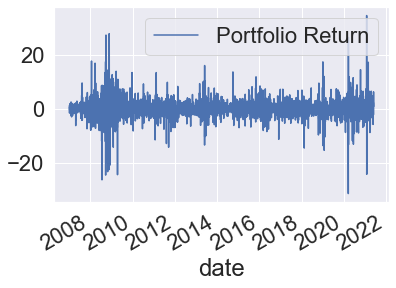

In [519]:
portfolio.plot()

In [520]:
portfolio.dropna(inplace = True)

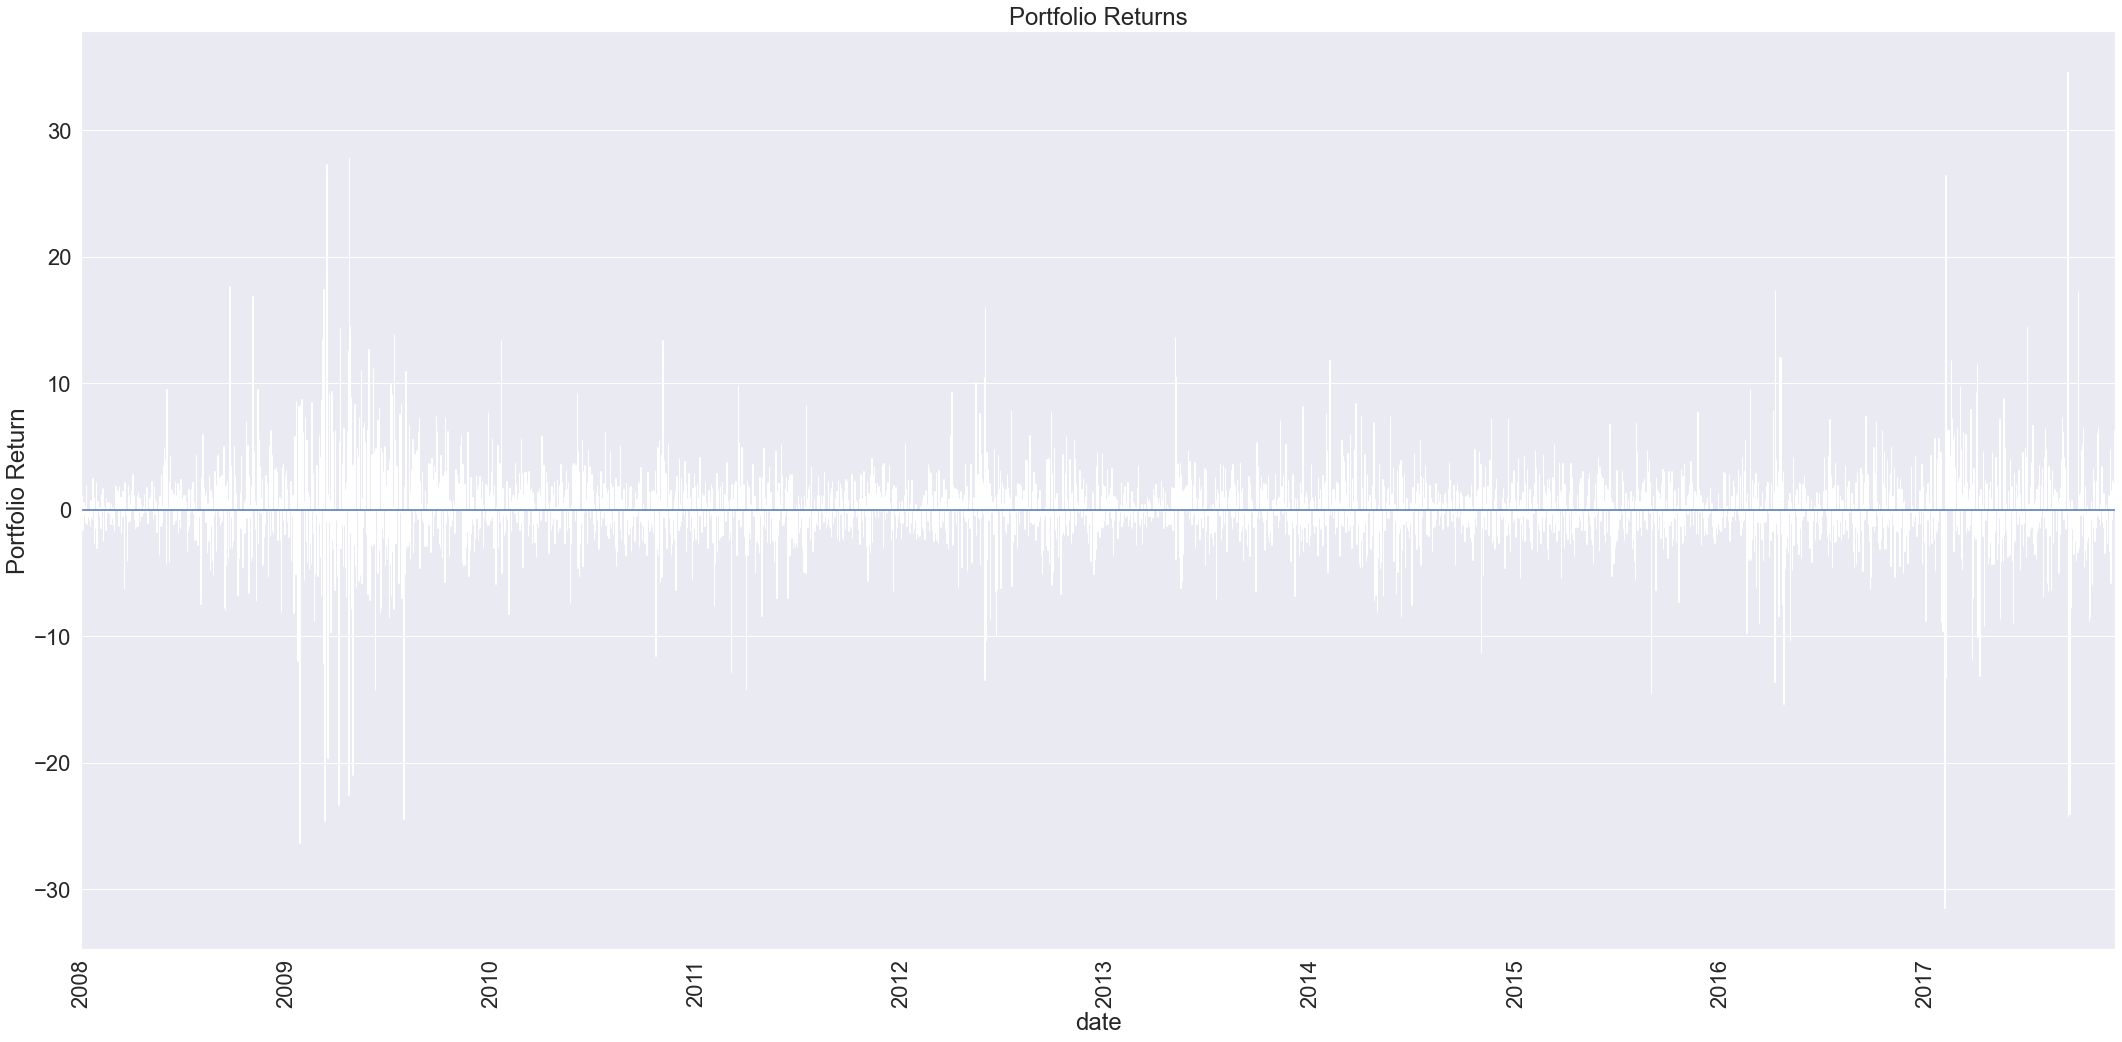

In [521]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(figsize=(30,15))
sns.barplot(x = portfolio.index, y = 'Portfolio Return', data = portfolio, color = 'grey')

axes.xaxis.set_major_locator(mdates.YearLocator())
axes.xaxis.set_minor_locator(mdates.MonthLocator())

ticklabels = [item.strftime('%Y') for item in portfolio.resample('Y').mean().index.to_period('Y')]

axes.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))

plt.xticks(rotation = 'vertical')
axes.set_title('Portfolio Returns')

sns.set(font_scale=2)
plt.axhline(0)

plt.tight_layout()


plt.show()

In [522]:
portfolio_monthly = portfolio.resample('M').mean()
portfolio_monthly

,Portfolio Return
date,
2007-01-31,-0.275276
2007-02-28,-0.064677
2007-03-31,-0.260868
2007-04-30,0.317659
2007-05-31,0.136799
...,...
2021-01-31,0.491378
2021-02-28,-1.863246
2021-03-31,-1.015891


In [523]:
avg_return = portfolio['Portfolio Return'].mean()
print(f'Average return is {avg_return:.2f} %')

Average return is 0.08 %


In [525]:
portfolio.to_csv('results/LinearRegression_PCA.csv')

In [444]:
rolling_avg = pd.DataFrame(data = df['Portfolio Return'].rolling(252).mean())

In [446]:
rolling_avg.dropna(inplace = True)

In [447]:
rolling_avg

,Portfolio Return
date,
2008-01-02,0.246002
2008-01-03,0.237357
2008-01-04,0.244239
2008-01-07,0.263288
2008-01-08,0.267650
...,...
2021-05-21,-0.566794
2021-05-24,-0.520837
2021-05-25,-0.482548


(array([13149., 13879., 14610., 15340., 16071., 16801., 17532., 18262.,
        18993.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

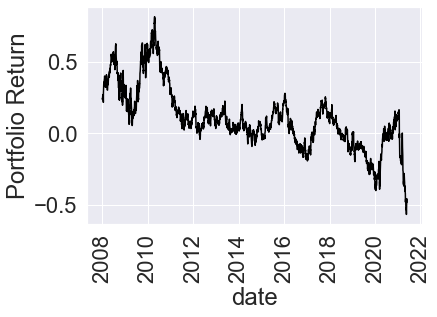

In [450]:
sns.lineplot(x = rolling_avg.index, y = 'Portfolio Return', data = rolling_avg, color = 'black')
plt.xticks(rotation = 'vertical')
